<a href="https://colab.research.google.com/github/hannahsophieMWB/machine_learning_MiT/blob/main/Bitcoin_Price_Prediction_Case_Study.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Bitcoin Price Prediction**


----------------
## **Context**
----------------

**Bitcoin is a decentralized digital currency** that uses encryption schemes, decentralized consensus, and other mechanisms to verify transactions and ensure security. It is a revolutionary cryptocurrency that has signaled a paradigm shift in the meaning of wealth and payments, and it has attracted extensive attention from investors, researchers, regulators as well as print & online media all over the world.

------------------
## **Objective**
------------------

An unusual feature of Bitcoin price is the **large fluctuation in contrast to traditional financial assets** (such as gold, stock indexes, and commodities). This dataset consists of monthly average closing prices of Bitcoin from Dec 2011 to March 2021. We have to build a time series model using the AR, MA, ARMA & ARIMA models to predict the monthly average closing price of Bitcoin.

--------------------------
## **Data Dictionary**
--------------------------

- `Timestamp`: Date when the price was collected
- `Close`: The closing price of Bitcoin

## **Importing libraries**

**Note**: The Statsmodels library is being downgraded to version 0.12.1 for this case study. This is because the library has only recently been updated, and the latest version may/may not give us the desired Time Series output results. The code below (!pip install statsmodels==0.12.1) may be run to downgrade the library to the right version.

Once the code runs successfully, you may either restart the kernel or restart the Jupyter Notebook before importing the Statsmodels library. It is enough to run the below installation cell for Statsmodels only once. To be sure you are using the correct version of the library, you can use the code in the version check cell right after, and **version 0.12.1** should be good to go.

In [1]:
# Installing the appropriate version of statsmodels library
!pip install statsmodels==0.12.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.4/17.4 MB 3.0 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × pip subprocess to install build dependencies did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Installing build dependencies ... error
error: subprocess-exited-with-error

× pip subprocess to install build dependencies did not run successfully.
│ exit code: 1
╰─> See above for output.

note: This error originates from a subprocess, and is likely not a problem with pip.


In [2]:
# Version check
import statsmodels

statsmodels.__version__

'0.14.1'

In [3]:
# Importing libraries for data manipulation
import pandas as pd

import numpy as np

# Importing libraries for data visualization
import matplotlib.pylab as plt

# Importing an advanced library for data visualization
import seaborn as sns

# Importing library for date manipulation
from datetime import datetime

# To calculate the MSE or RMSE
from sklearn.metrics import mean_squared_error

# Importing acf and pacf functions
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Importing models from statsmodels library
from statsmodels.tsa.ar_model import AutoReg

from statsmodels.tsa.arima.model import ARIMA

# To ignore the warnings
import warnings
warnings.filterwarnings('ignore')

In [4]:
# mount GDrive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Loading the dataset**

In [ ]:
# Loading the dataset
df = pd.read_csv('bitcoin.csv')

# Looking at first five records of the data
df.head()

,Timestamp,Close
0,31-12-2011,4.482500
1,31-01-2012,6.208932
2,29-02-2012,5.252514
3,31-03-2012,4.961054
4,30-04-2012,4.976416


## **Checking the info**

In [ ]:
# Method to check the info of the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112 entries, 0 to 111
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Timestamp  112 non-null    object 
 1   Close      112 non-null    float64
dtypes: float64(1), object(1)
memory usage: 1.9+ KB


**Observations:**

- There are **112 observations and 2 columns** in the data.
- The Timestamp column is of object data type and the closing price is of float data type. We must **convert the `Timestamp` column to datetime data type.**
- There are **no missing values** in the dataset.

In [ ]:
# Converting Timestamp to datetime data type
df.Timestamp = pd.to_datetime(df.Timestamp, infer_datetime_format = True)

Here, **we don't need datetime as a column** because we only need values to build the model. So, we can keep the dates as an index instead of a column in the data.

In [ ]:
# Setting date as the index
df = df.set_index(['Timestamp'])

df.head()

,Close
Timestamp,
2011-12-31,4.482500
2012-01-31,6.208932
2012-02-29,5.252514
2012-03-31,4.961054
2012-04-30,4.976416


Now, let's **visualize the time series** to get an idea how about the trend and/or seasonality within the data.

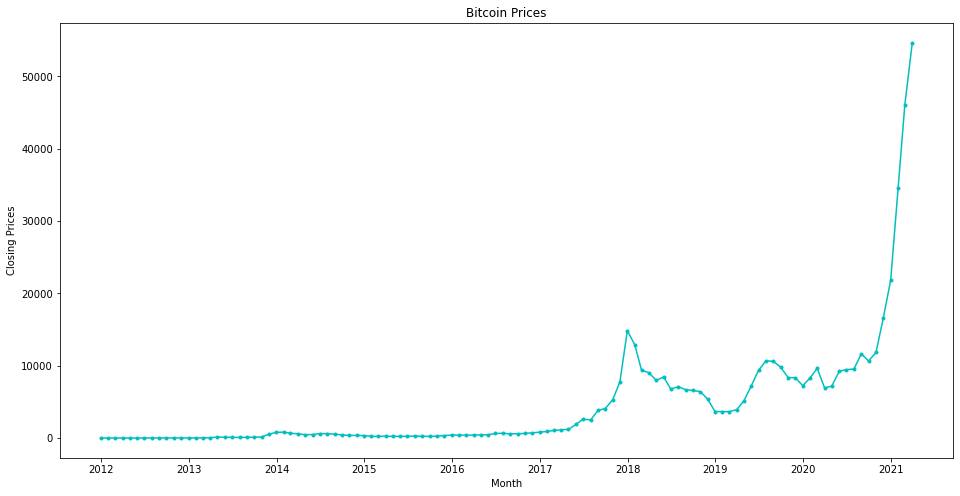

In [ ]:
# Visualizing the time series
plt.figure(figsize=(16, 8))

plt.xlabel("Month")

plt.ylabel("Closing Prices")

plt.title('Bitcoin Prices')

plt.plot(df.index, df.Close, color = 'c', marker = '.')

**Observations:**
- We can see that the series has an **upward trend with some seasonality.** The prices have started significantly rising since 2017, and there have been rapid fluctuations since then. **The value of Bitcoin has also increased tremendously in the year 2021 alone.**
- Before building different models, it is important to **check whether the series is stationary or not.**

Let us first split the dataset into train and test data.

## **Splitting the dataset**

We'll consider the data from the **last 12 months as the test data** and the remaining data as the train data.

In [ ]:
# Splitting the data into train and test sets
df_train, df_test = df.iloc[:-12], df.iloc[-12:]

print(df_train)

print(df_test)

                  Close
Timestamp              
2011-12-31     4.482500
2012-01-31     6.208932
2012-02-29     5.252514
2012-03-31     4.961054
2012-04-30     4.976416
...                 ...
2019-11-30  8342.407325
2019-12-31  7240.923794
2020-01-31  8321.166136
2020-02-29  9646.348210
2020-03-31  6928.948538

[100 rows x 1 columns]
                   Close
Timestamp               
2020-04-30   7181.912395
2020-05-31   9236.102515
2020-06-30   9459.375927
2020-07-31   9545.246114
2020-08-31  11636.379750
2020-09-30  10654.757360
2020-10-31  11836.958820
2020-11-30  16530.432870
2020-12-31  21811.295270
2021-01-31  34553.599450
2021-02-28  46077.063200
2021-03-31  54641.412970


Now, let us check the **rolling mean and standard deviation** of the series to **visualize if the series has any trend or seasonality.**

## **Testing the stationarity of the series**

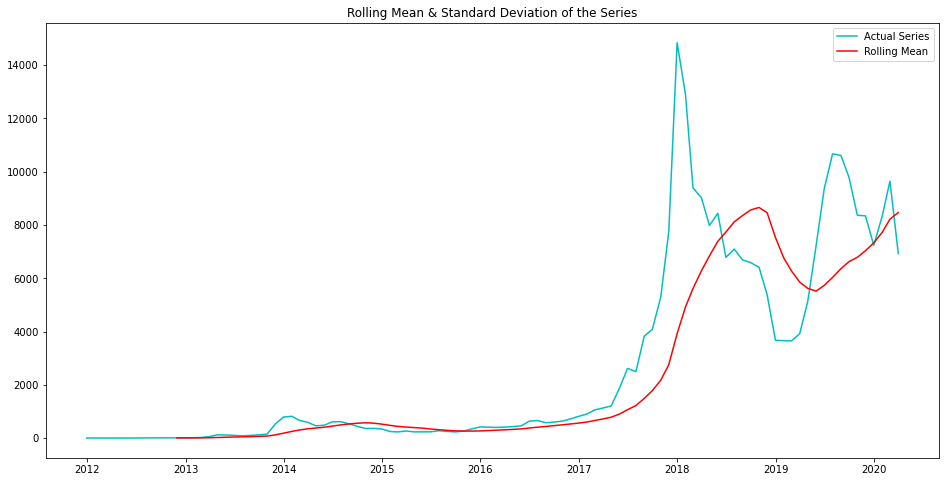

In [ ]:
# Calculating the rolling mean and standard deviation for a window of 12 observations
rolmean = df_train.rolling(window = 12).mean()

rolstd = df_train.rolling(window = 12).std()

# Visualizing the rolling mean and standard deviation
plt.figure(figsize = (16, 8))

actual = plt.plot(df_train, color = 'c', label = 'Actual Series')

rollingmean = plt.plot(rolmean, color = 'red', label = 'Rolling Mean')

plt.title('Rolling Mean & Standard Deviation of the Series')

plt.legend()

plt.show()

**Observations:**
- We can see that **there is an upward trend in the series.**
- We can confirm that **the series is not stationary.**

We can also use the **Augmented Dickey-Fuller (ADF) Test** to verify if the series is stationary or not.
The null and alternate hypotheses for the ADF Test are defined as:
- **Null hypothesis:** The Time Series is non-stationary
- **Alternative hypothesis:** The Time Series is stationary

In [ ]:
# Define a function to use adfuller test
def adfuller(data):

  #Importing adfuller using statsmodels
    from statsmodels.tsa.stattools import adfuller

    print('Dickey-Fuller Test: ')

    adftest = adfuller(data['Close'])

    adfoutput = pd.Series(adftest[0:4], index = ['Test Statistic', 'p-value', 'Lags Used', 'No. of Observations'])

    for key, value in adftest[4].items():
        adfoutput['Critical Value (%s)'%key] = value

    print(adfoutput)

    adfuller(df_train)

**Observations:**
1. From the above test, we can see that the **p-value is around 0.36, i.e., > 0.05** (for 95% confidence intervals) therefore, **we fail to reject the null hypothesis.**
2. Hence, **we can confirm that the series is non-stationary.**

## **Making the series stationary**

We can use some of the following methods to convert a non-stationary series into a stationary one:
1. **Log Transformation**
2. **By differencing the series (lagged series)**

Let's first use a log transformation over this series to remove exponential variance and check the stationarity of the series again.

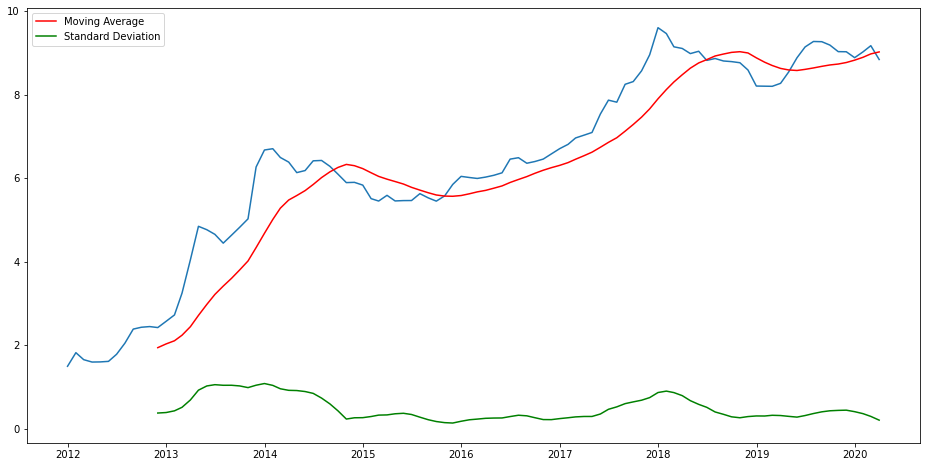

In [ ]:
# Visualize the rolling mean and standard deviation after using log transformation
plt.figure(figsize = (16, 8))

df_log = np.log(df_train)

MAvg = df_log.rolling(window = 12).mean()

MStd = df_log.rolling(window = 12).std()

plt.plot(df_log)

plt.plot(MAvg, color='r', label = 'Moving Average')

plt.plot(MStd, color='g', label = 'Standard Deviation')

plt.legend()

plt.show()

**Observations:**
- Since **we can still see the upward trend in the series**, we can conclude that **the series is still non-stationary.**
- However, the standard deviation is almost constant, which implies that **now the series has a constant variance.**

**Let's shift the series by order 1 (or by 1 month) and apply differencing (using lagged series),** and then check the rolling mean and standard deviation.

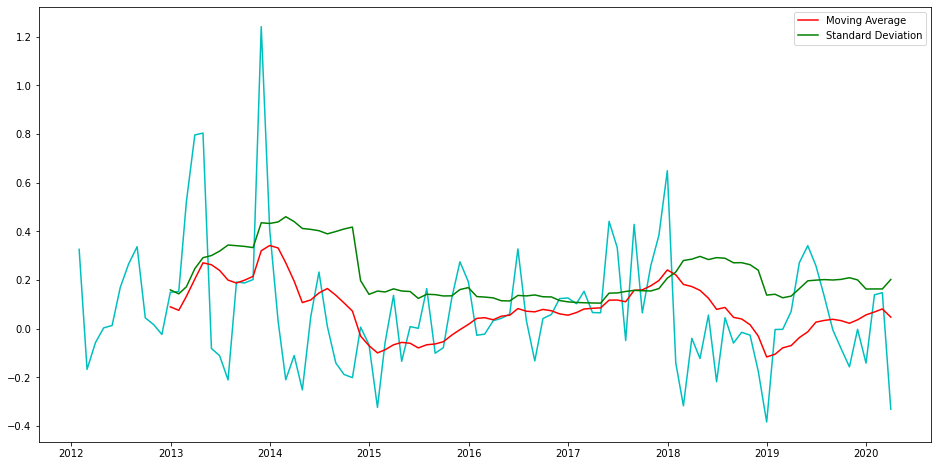

In [ ]:
# Fixing the figure size
plt.figure(figsize = (16, 8))

df_shift = df_log - df_log.shift(periods = 1)

MAvg_shift = df_shift.rolling(window = 12).mean()

MStd_shift = df_shift.rolling(window = 12).std()

plt.plot(df_shift, color = 'c')

plt.plot(MAvg_shift, color = 'red', label = 'Moving Average')

plt.plot(MStd_shift, color = 'green', label = 'Standard Deviation')

plt.legend()

plt.show()

# Dropping the null values that we get after applying differencing method
df_shift = df_shift.dropna()

**Observations:**
- **The mean and the standard deviation seem to be constant over time.** Let us use the adfuller test to check the stationarity.

In [ ]:
adfuller(df_shift)

Dickey-Fuller Test: 
Test Statistic         -6.174833e+00
p-value                 6.669466e-08
Lags Used               0.000000e+00
No. of Observations     9.800000e+01
Critical Value (1%)    -3.498910e+00
Critical Value (5%)    -2.891516e+00
Critical Value (10%)   -2.582760e+00
dtype: float64


**Observations:**
- We can see that **the p-value is now far lesser than 0.05** (for 95% confidence interval), **therefore, we can reject the null hypothesis that the series is non-stationary.**

We can conclude that **the series is now stationary.** Let's decompose the time series to check its different components.

## **Decomposing the time series components into Trend, Seasonality, and Residual**

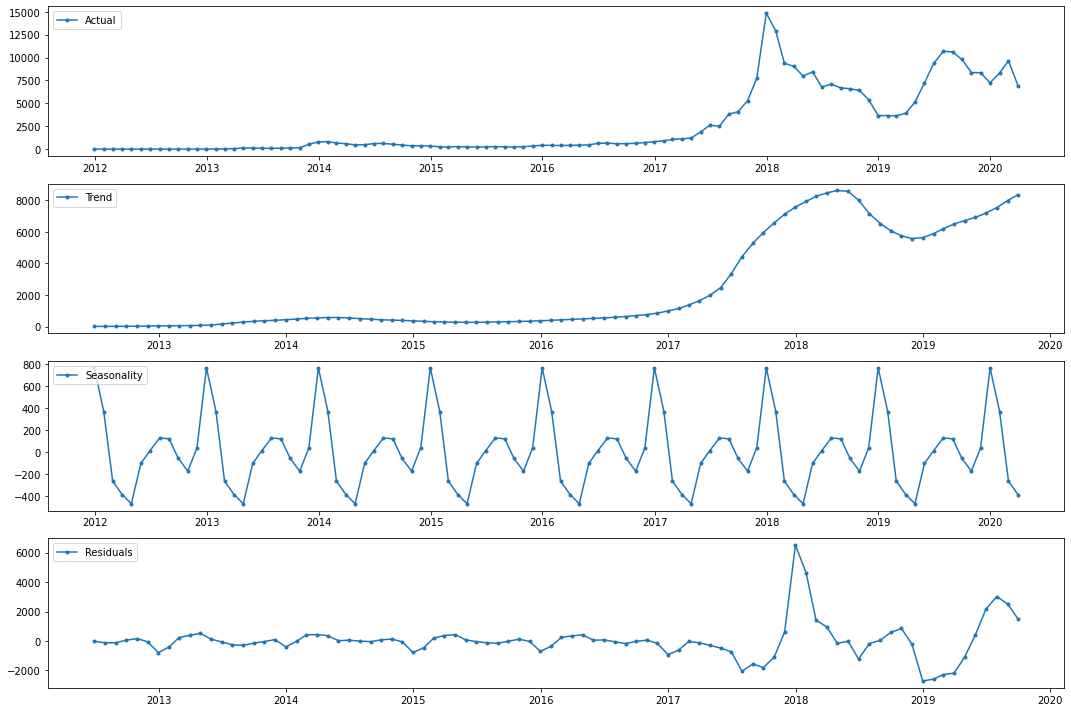

In [ ]:
# Importing the seasonal_decompose to decompose the time series
from statsmodels.tsa.seasonal import seasonal_decompose

decomp = seasonal_decompose(df_train)

trend = decomp.trend

seasonal = decomp.seasonal

residual = decomp.resid

plt.figure(figsize = (15, 10))

plt.subplot(411)

plt.plot(df_train, label = 'Actual', marker = '.')

plt.legend(loc = 'upper left')

plt.subplot(412)

plt.plot(trend, label = 'Trend', marker = '.')

plt.legend(loc = 'upper left')

plt.subplot(413)

plt.plot(seasonal, label = 'Seasonality', marker = '.')

plt.legend(loc = 'upper left')

plt.subplot(414)

plt.plot(residual, label = 'Residuals', marker = '.')

plt.legend(loc = 'upper left')

plt.tight_layout()

**Observations:**
- We can observe significant **trend, seasonality, and residuals components** in the series.
- The plot for seasonality shows that the **Bitcoin price spikes from December to January and then drops constantly till May.**

**Now, let's move on to the model building section. First, we will plot the `ACF` and `PACF` plots to get the values of p and q, i.e., the order of AR and MA models to be used.**

## **ACF and PACF plots**

**Plotting the auto-correlation function and partial auto-correlation function to get p and q values for AR, MA, ARMA, and ARIMA models.**

<Figure size 1152x576 with 0 Axes>

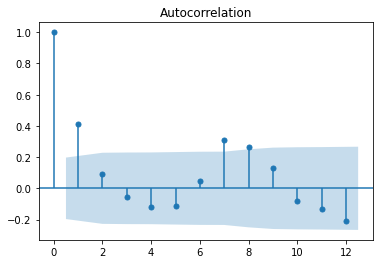

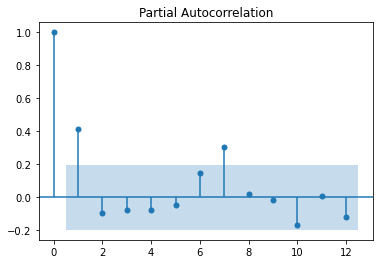

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize = (16, 8))

plot_acf(df_shift, lags = 12)

plt.show()

plot_pacf(df_shift, lags = 12)

plt.show()

**Observations:**
- From the above PACF plot, we observe that **the highest lag** at which the plot extends beyond the statistically significant boundary is **lag 7.**
- This indicates that an **AR Model of lag 7 (p = 7)** should be sufficient to fit the data.
- Similarly, from the ACF plot, we can infer that **q = 7.**

## **AR Model**

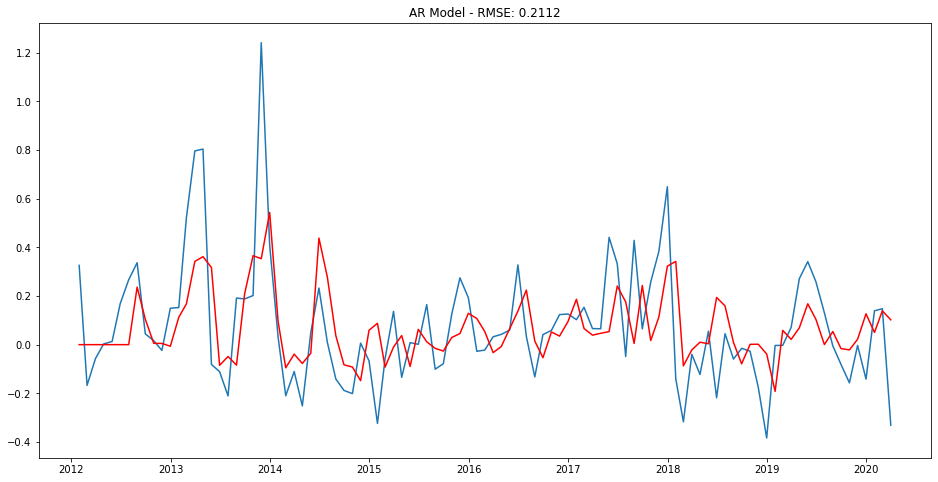

In [ ]:
# Importing AutoReg function to apply AR model
from statsmodels.tsa.ar_model import AutoReg

plt.figure(figsize = (16, 8))

# Using number of lags as 7
model_AR = AutoReg(df_shift, lags = 7)

results_AR = model_AR.fit()

plt.plot(df_shift)

predict = results_AR.predict(start = 0, end = len(df_shift) - 1)

# Converting NaN values to 0
predict = predict.fillna(0)

plt.plot(predict, color = 'red')

# Calculating rmse
plt.title('AR Model - RMSE: %.4f'% mean_squared_error(predict, df_shift['Close'], squared = False))

plt.show()

- We can see that **by using the AR model, we get root mean squared error (RMSE) = 0.2112**.

**Let's check the AIC value** of the model.

In [ ]:
# Checking the AIC value
results_AR.aic

-2.896354867736574

Now, let's build MA, ARMA, and ARIMA models and see if we can get a better model.

## **MA Model**

**We will be using an ARIMA model with p = 0 and d = 0 so that it works as an MA model.**

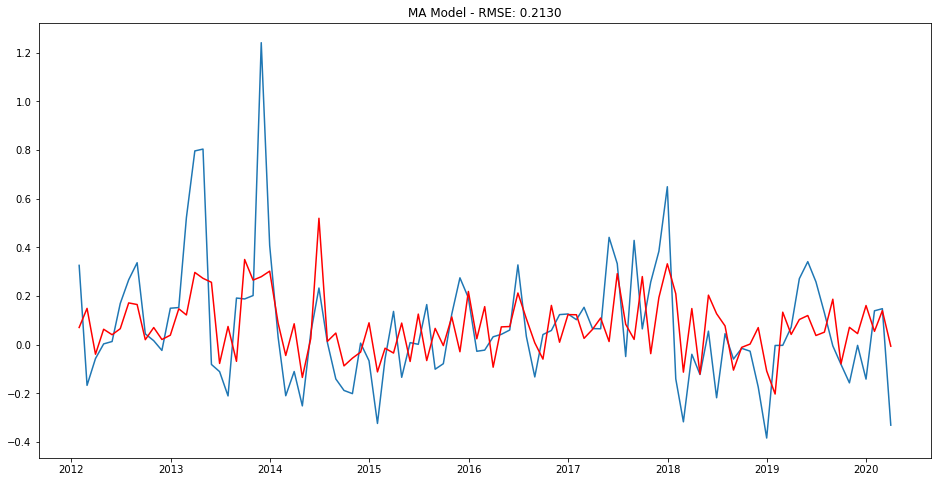

In [ ]:
plt.figure(figsize = (16, 8))

# Using p=0, d = 0, q = 7
model_MA = ARIMA(df_shift, order = (0, 0, 7))

results_MA = model_MA.fit()

plt.plot(df_shift)

plt.plot(results_MA.fittedvalues, color = 'red')

plt.title('MA Model - RMSE: %.4f'% mean_squared_error(results_MA.fittedvalues, df_shift['Close'], squared = False))

plt.show()

- **The MA model is giving a slightly higher RMSE** when compared to the AR model.

Let's check the AIC value of the model.

In [ ]:
# Calculating the AIC value
results_MA.aic

-6.990669442934323

- **The MA model is giving a lower AIC** when compared to the AR model, implying that **the MA model fits the training data better.**

## **ARMA Model**

We will be using an **ARIMA model with p = 7 and q = 7** (as observed from the ACF and PACF plots) **and d = 0 so that it works as an ARMA model.**

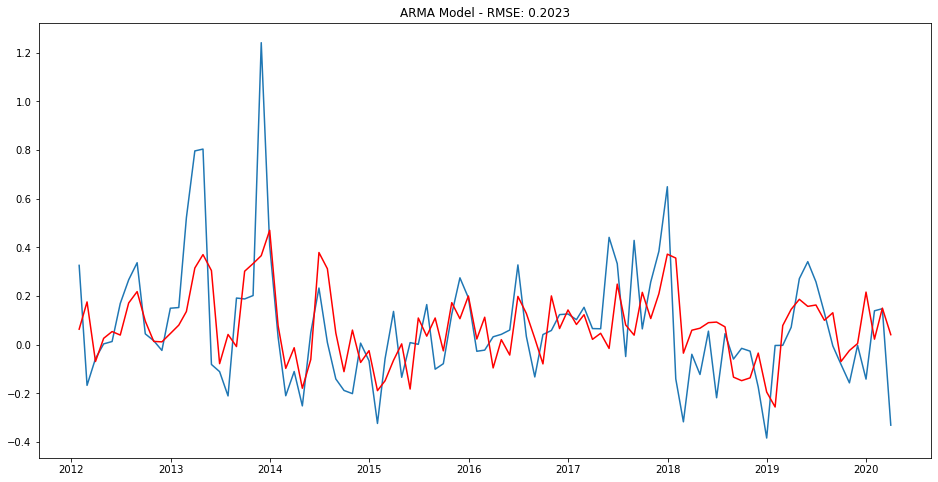

In [ ]:
plt.figure(figsize = (16, 8))

# Using p = 7, d = 0, q = 7
model_ARMA = ARIMA(df_shift, order = (7, 0, 7))

results_ARMA = model_ARMA.fit()

plt.plot(df_shift)

plt.plot(results_ARMA.fittedvalues, color = 'red')

plt.title('ARMA Model - RMSE: %.4f'% mean_squared_error(results_ARMA.fittedvalues, df_shift['Close'], squared = False))

plt.show()

- **The ARMA model is giving a lower RMSE in comparison to AR and MA models.**

**Let's check the AIC value** of the model.

In [ ]:
# Calculating the AIC value
results_ARMA.aic

-3.977161535060347

- **The AIC value of the ARMA model is less than the AR model but greater than the MA model.**

**Let us try using the ARIMA model.**

## **ARIMA Model**

We will be using an **ARIMA model with p = 7, d = 1, & q = 7**.

Since we are using d = 1 in the ARIMA model, it will result in double differencing of the df_log series. So, we need double shifted series in order to calculate the RMSE of the model.

In [ ]:
# Getting double differenced series
df_shift2 = df_log - df_log.shift(periods = 2)

df_shift2.dropna(inplace = True)

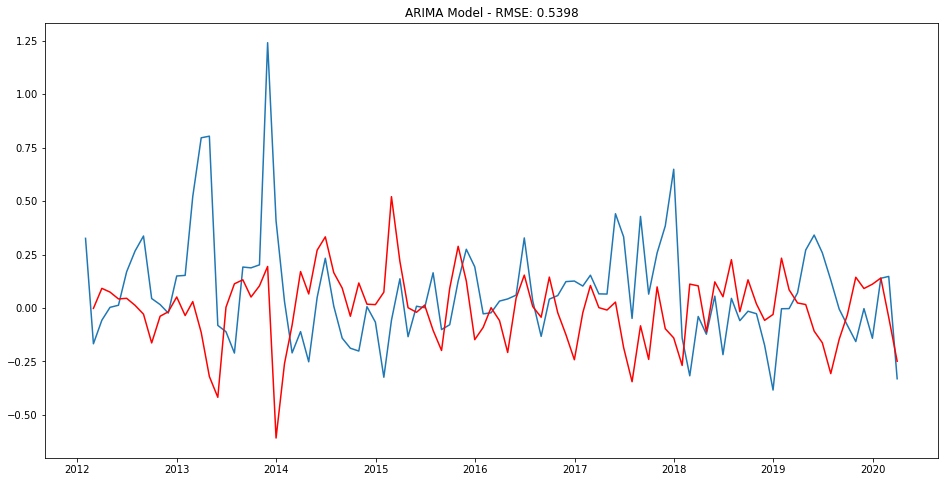

In [ ]:
from statsmodels.tsa.arima_model import ARIMA

plt.figure(figsize = (16, 8))

# Using p = 7, d = 1, q = 7
model_ARIMA = ARIMA(df_shift, order = (7, 1, 7))

results_ARIMA = model_ARIMA.fit()

plt.plot(df_shift)

plt.plot(results_ARIMA.fittedvalues, color = 'red')

plt.title('ARIMA Model - RMSE: %.4f'% mean_squared_error(results_ARIMA.fittedvalues, df_shift2['Close'], squared = False))

plt.show()

- **The ARIMA model is giving a higher RMSE than other models.**

**Let's check the AIC value** of the model.

In [ ]:
# Calculating the AIC
results_ARIMA.aic

5.122248793235144

- **The AIC value of the ARIMA model is much higher as compared to previous models.**

We can see that the ARMA model is giving the least RMSE and the second-lowest AIC value among all the models.

**We can choose to predict the values using ARMA model.**

In [ ]:
# Printing the fitted values
predictions = pd.Series(results_ARMA.fittedvalues)

predictions

Timestamp
2012-01-31    0.063516
2012-02-29    0.175579
2012-03-31   -0.069248
2012-04-30    0.025993
2012-05-31    0.053821
                ...   
2019-11-30    0.004503
2019-12-31    0.215969
2020-01-31    0.022533
2020-02-29    0.150100
2020-03-31    0.040955
Length: 99, dtype: float64

## **Inverse Transformation**

Now that we have fitted values using the ARIMA model, **we will use the inverse transformation to get back the original values.**

In [ ]:
# First step - doing cumulative sum
predictions_cumsum = predictions.cumsum()

predictions_cumsum

Timestamp
2012-01-31    0.063516
2012-02-29    0.239095
2012-03-31    0.169847
2012-04-30    0.195840
2012-05-31    0.249660
                ...   
2019-11-30    6.826117
2019-12-31    7.042086
2020-01-31    7.064619
2020-02-29    7.214720
2020-03-31    7.255674
Length: 99, dtype: float64

In [ ]:
# Second step - adding the first value of the log series to the cumulative sum values
predictions_log = pd.Series(df_log['Close'].iloc[0], index = df_log.index)

predictions_log = predictions_log.add(predictions_cumsum, fill_value = 0)

predictions_log

Timestamp
2011-12-31    1.500181
2012-01-31    1.563697
2012-02-29    1.739276
2012-03-31    1.670028
2012-04-30    1.696021
                ...   
2019-11-30    8.326298
2019-12-31    8.542267
2020-01-31    8.564800
2020-02-29    8.714900
2020-03-31    8.755855
Length: 100, dtype: float64

In [ ]:
# Third step - applying exponential transformation
predictions_ARMA = np.exp(predictions_log)

predictions_ARMA

Timestamp
2011-12-31       4.482500
2012-01-31       4.776446
2012-02-29       5.693218
2012-03-31       5.312315
2012-04-30       5.452207
                 ...     
2019-11-30    4131.096953
2019-12-31    5126.953046
2020-01-31    5243.792685
2020-02-29    6093.028024
2020-03-31    6347.747056
Length: 100, dtype: float64

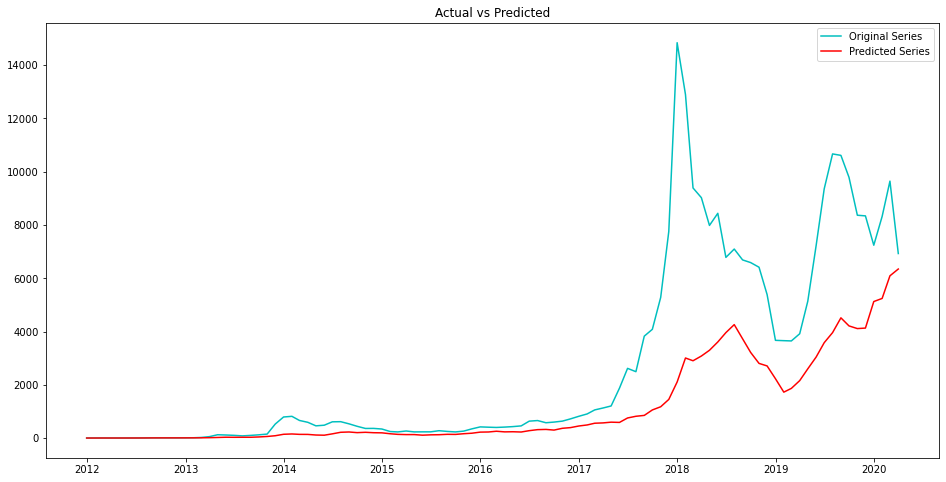

In [ ]:
# Plotting the original vs predicted series
plt.figure(figsize = (16, 8))

plt.plot(df_train, color = 'c', label = 'Original Series')

plt.plot(predictions_ARMA, color = 'r', label = 'Predicted Series')

plt.title('Actual vs Predicted')

plt.legend()

plt.show()

**Observations:**
- We can see that **the predicted series is similar to the original series**, i.e., the model is good at predicting values on the training data except for the high spike in prices in 2018 and towards the end of 2019 which may have been due to some external factors that are not included in this model.
- Let us **forecast the closing prices for the next 12 months.**

## **Forecasting the values for the next 12 months and comparing it with the test data**

**To forecast the values for the next 12 months using the ARMA model, we need to follow the steps below:**
1. Forecast the log-transformed fitted values for the next 12 months.
2. Make a list of these 12 months' forecasted values.
3. Convert that list into a series so that we can work with pandas functions.
4. Make a dataframe where we have the dates starting from 2020-04-30 to 2021-03-31 as the index and the respective forecasted values.
5. Apply the inverse transformation and get the real forecasted values.

In [ ]:
# Forecasting the values for next 12 months where 'steps' represent the number of months
forecasted_ARMA = results_ARMA.forecast(steps = 12)

forecasted_ARMA

2020-04-30   -0.054556
2020-05-31   -0.064410
2020-06-30   -0.078542
2020-07-31   -0.171618
2020-08-31    0.015209
2020-09-30   -0.014593
2020-10-31   -0.091945
2020-11-30   -0.069636
2020-12-31    0.085818
2021-01-31    0.119683
2021-02-28    0.042017
2021-03-31    0.046711
Freq: M, Name: predicted_mean, dtype: float64

In [ ]:
# Creating a series of cumulative sum
forecasted_cumsum = forecasted_ARMA.cumsum()

forecasted_cumsum

2020-04-30   -0.054556
2020-05-31   -0.118966
2020-06-30   -0.197508
2020-07-31   -0.369126
2020-08-31   -0.353918
2020-09-30   -0.368511
2020-10-31   -0.460457
2020-11-30   -0.530092
2020-12-31   -0.444274
2021-01-31   -0.324591
2021-02-28   -0.282574
2021-03-31   -0.235863
Freq: M, Name: predicted_mean, dtype: float64

In [ ]:
# Making a new dataframe to get the the indices from 2020-2021
index = pd.date_range('2020-04-30', '2021-03-31', freq = '1M')

df1 = pd.DataFrame()

df1['cumsum'] = forecasted_cumsum

df1.index = index

df1

,cumsum
2020-04-30,-0.054556
2020-05-31,-0.118966
2020-06-30,-0.197508
2020-07-31,-0.369126
2020-08-31,-0.353918
2020-09-30,-0.368511
2020-10-31,-0.460457
2020-11-30,-0.530092
2020-12-31,-0.444274
2021-01-31,-0.324591


In [ ]:
# Adding the last value of the log of the training data
df1['Forecasted'] = df1['cumsum'] + float(df_log.loc['2020-03-31'])

df1

,cumsum,Forecasted
2020-04-30,-0.054556,8.788907
2020-05-31,-0.118966,8.724498
2020-06-30,-0.197508,8.645955
2020-07-31,-0.369126,8.474337
2020-08-31,-0.353918,8.489546
2020-09-30,-0.368511,8.474952
2020-10-31,-0.460457,8.383007
2020-11-30,-0.530092,8.313371
2020-12-31,-0.444274,8.399189
2021-01-31,-0.324591,8.518872


In [ ]:
# Applying the exponential transformation to the forecasted log values
forecasted_ARMA = np.exp(df1['Forecasted'])

forecasted_ARMA

2020-04-30    6561.059775
2020-05-31    6151.785666
2020-06-30    5687.097087
2020-07-31    4790.245815
2020-08-31    4863.655247
2020-09-30    4793.194094
2020-10-31    4372.135355
2020-11-30    4078.037901
2020-12-31    4443.462575
2021-01-31    5008.403181
2021-02-28    5223.325482
2021-03-31    5473.100227
Freq: M, Name: Forecasted, dtype: float64

Now, let's try to visualize the original data with the predicted values on the training data and the forecasted values.

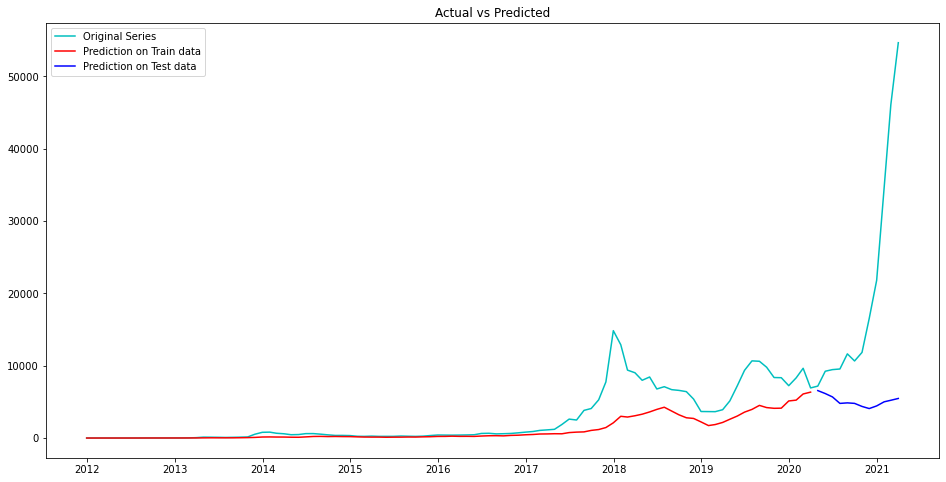

In [ ]:
# Plotting the original vs predicted series
plt.figure(figsize = (16, 8))

plt.plot(df, color = 'c', label = 'Original Series')

plt.plot(predictions_ARMA, color = 'r', label = 'Prediction on Train data')

plt.plot(forecasted_ARMA, label = 'Prediction on Test data', color = 'b')

plt.title('Actual vs Predicted')

plt.legend()

plt.show()

**Observations:**

- **As observed earlier, most of the predicted values on the training data are close to the actual values** except for the spike in the prices in the year 2018 and at the end of 2019.
- **On the test data, the model is not performing well**, as we can see that the blue line appears to be far away from the actual values (cyan blue). The actual values have a steep upwards trend, but the predicted values have a somewhat downward trend. Also, the test predictions are not able to identify the volatile variations in the prices over the last 12 months.

Let's test the RMSE of the transformed predictions and the original value on the training and testing data to check whether the model is giving a generalized performance or not.

In [ ]:
from sklearn.metrics import mean_squared_error

error = mean_squared_error(predictions_ARMA, df_train, squared = False)

error

2777.426793022376

In [ ]:
from sklearn.metrics import mean_squared_error

error = mean_squared_error(forecasted_ARMA, df_test, squared = False)

error

21600.27610454486

## **Conclusion**

- **Aligned to our observation earlier, the RMSE is lower on the training data** in comparison to the testing data. This implies that the predictions on the training data are closer to the actual values in comparison to the testing data.
- This might be because **there have been many fluctuations in the Bitcoin prices over the last 12 months.** As evident from the above plot, the prices have a steeper trend and more variation in the final year. Our model hasn't learned this from the pattern of previous years and hence the predicted values are not at all close to the actual values.
- As mentioned earlier, one of the varied features of Bitcoin is its large fluctuations in the prices over the last decade. **Our model might not be complex enough to capture these fluctuations - Spikes and Dips.** We can further try to build more complex time series models like SARIMA, SARIMAX, etc., while considering more factors like trend, seasonality, etc. and check if we can get a more generalized model.